In [1]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from environments import Environment
from agents import Agent, EpsilonGreedyAgent, UcbAgent


N_RUNS = 500
N_STEPS = 1000
EPSILON = 0.1

random.seed(1001)
np.random.seed(1001)

In [2]:
class MultiArmedBanditEnv(Environment):
    def __init__(self, num_arms, arms_prob):
        super().__init__(state_size=1, action_size=num_arms)
        self.true_means = arms_prob
    
    def step(self, state, action):
        return 1 if (np.random.random()  < self.true_means[action]) else 0
    
    def action_space(self):
        return range(self.action_size)
    
    def state_space(self):
        pass
    
    def reset(self):
        pass
    
    def is_terminal(self, state):
        return False
    
    def is_obstacle(self, state):
        return False


In [3]:
def plot_action_value_vs_true_prob(qvalue, true_prob):
    estimated_data = pd.DataFrame({
        'Arm': range(len(true_prob)),
        'Reward': qvalue,
        'Type': 'Learned Q-value'
    })

    true_data = pd.DataFrame({
        'Arm': range(len(true_prob)),
        'Reward': true_prob,
        'Type': 'True Probability'
    })

    plot_data = pd.concat([estimated_data, true_data])

    plt.figure(figsize=(14, 7))

    sns.barplot(data=plot_data, x='Arm', y='Reward', hue='Type', palette='bright')
    plt.title('True Prob. of Positive Reward vs Learned Q-values')
    plt.show()

def plot_cumulative_rewards(reward_history_avg):
    data = pd.DataFrame({
        'Rewards': reward_history_avg,
        'Steps': np.arange(N_STEPS)
    })
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data, x='Steps', y='Rewards')
    plt.title('Cumulative Rewards Collected Over Steps')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Rewards')
    plt.show()

def plot_arm_selection_percentage(action_history_avg, true_probs):
    data = pd.DataFrame(action_history_avg * 100, columns=[f'Arm #{i+1} ({(true_probs[i]*100):.0f}%)' for i in range(len(true_probs))])
    data['Steps'] = np.arange(N_STEPS)
    data = pd.melt(data, id_vars=['Steps'], var_name='Arm', value_name='Percentage')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data, x='Steps', y='Percentage', hue='Arm', palette='bright')
    plt.title('Avg. Percentage of selections for each Arm on each steps')
    plt.xlabel('Steps')
    plt.ylabel('Selection by Agent(%)')
    plt.legend(title='Arms')
    plt.show()

In [4]:
class MultiArmBanditEpGreedyAgent(EpsilonGreedyAgent):
    def __init__(self, env: Environment, epsilon=0.1):
        super().__init__(env, epsilon)
        self.n_pulls = np.zeros(env.action_size)

    def select_action(self, state):
        action = super().select_action(state)
        self.n_pulls[action] += 1
        return action
    
    def update(self, state, action, reward):
        self.q_value[state][action] += (reward - self.q_value[state][action]) / self.n_pulls[action]

    def reset(self):
        super().reset()
        self.n_pulls = np.zeros(self.env.action_size)

class MultiArmBanditUcbAgent(UcbAgent):
    def update(self, state, action, reward):
        self.q_value[state][action] += (reward - self.q_value[state][action]) / self.counts[action]


In [5]:
def run_experiment(env: Environment, agent: Agent, num_steps, num_runs):
    reward_history = np.zeros(num_steps)
    action_history = np.zeros((num_steps, env.action_size))

    for run in range(num_runs):
        rewards = []
        agent.reset()

        for step in tqdm(
            range(num_steps), desc=f"Run {run}/{num_runs} - Steps", leave=False
        ):
            action = agent.select_action(0)
            
            reward = env.step(0, action)

            agent.update(0, action, reward)

            rewards.append(reward)
            action_history[step][action] += 1
        
        reward_history += np.array(rewards)

    return agent.q_value[0], reward_history / num_runs, action_history / num_runs


In [6]:
num_arms= 5
arms_prob = [0.1, 0.3, 0.6, 0.85, 0.9]
env = MultiArmedBanditEnv(num_arms=num_arms, arms_prob=arms_prob)
agent = MultiArmBanditEpGreedyAgent(env)
qvalue, reward_history_avg, action_history_avg = run_experiment(env, agent, num_steps=N_STEPS, num_runs=N_RUNS)

Run 1/500 - Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

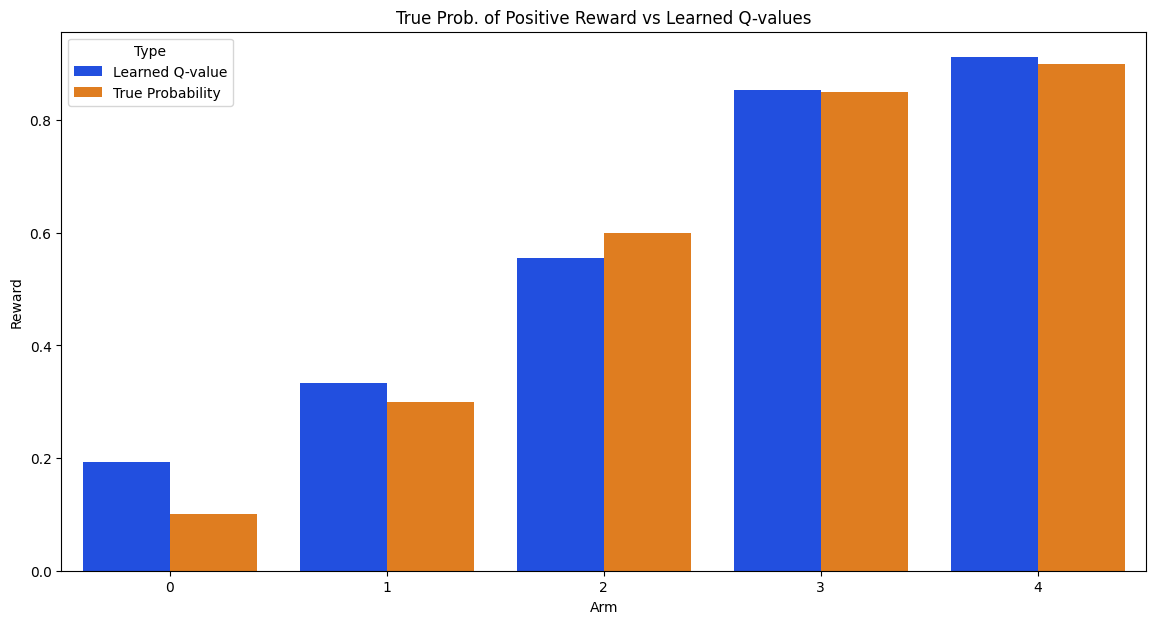

In [7]:
plot_action_value_vs_true_prob(qvalue, arms_prob)

As we can see the agent has learned to give the arms an action value proportional to their probability

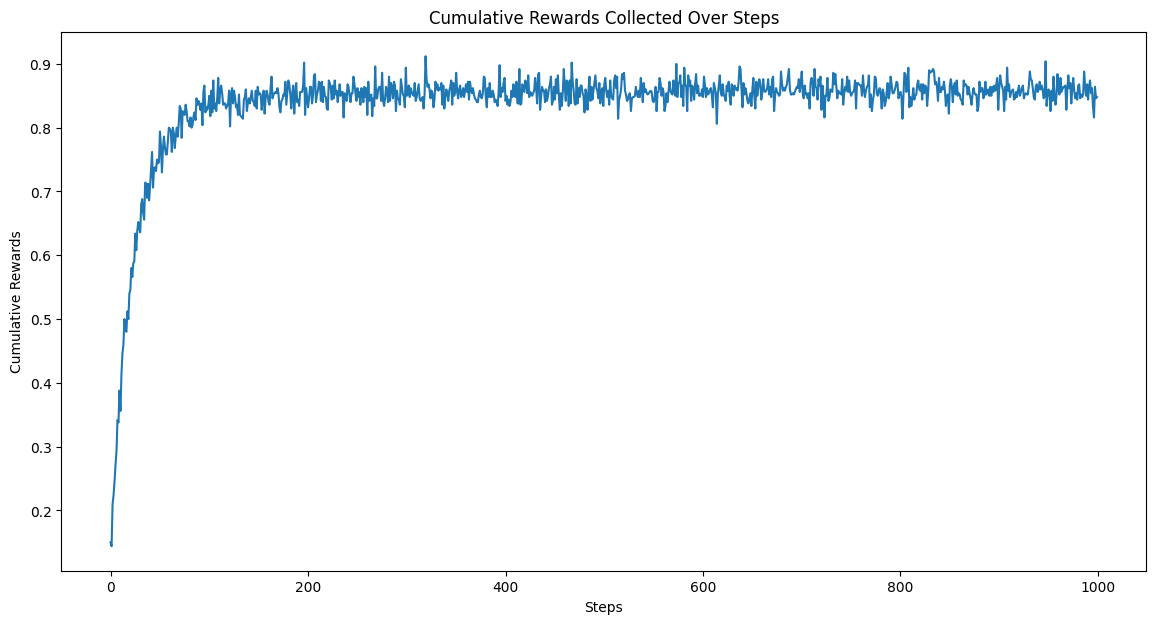

In [8]:
plot_cumulative_rewards(reward_history_avg)

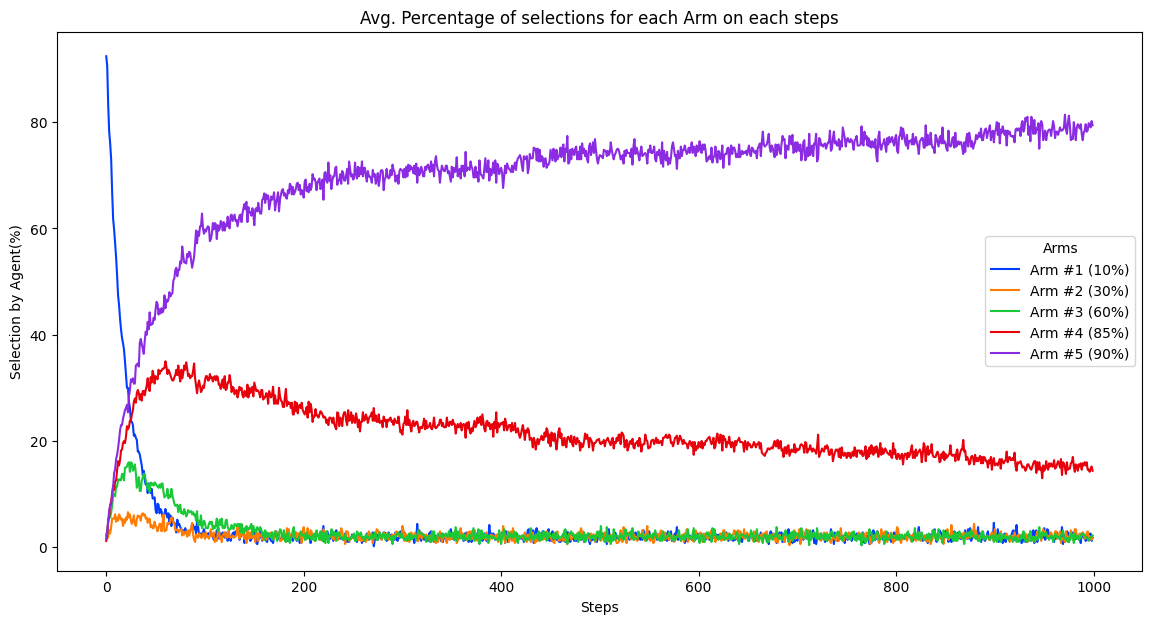

In [9]:
plot_arm_selection_percentage(action_history_avg, arms_prob)

In [10]:
agent = MultiArmBanditUcbAgent(env)
qvalue, reward_history_avg, action_history_avg = run_experiment(env, agent, num_steps=N_STEPS, num_runs=N_RUNS)

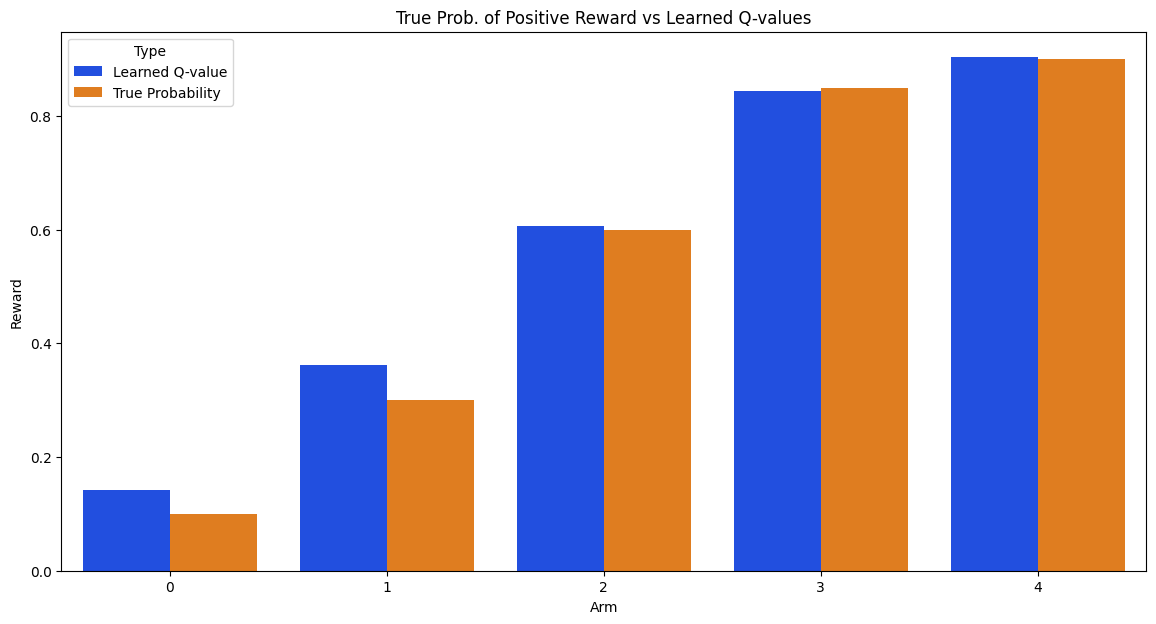

In [11]:
plot_action_value_vs_true_prob(qvalue, arms_prob)

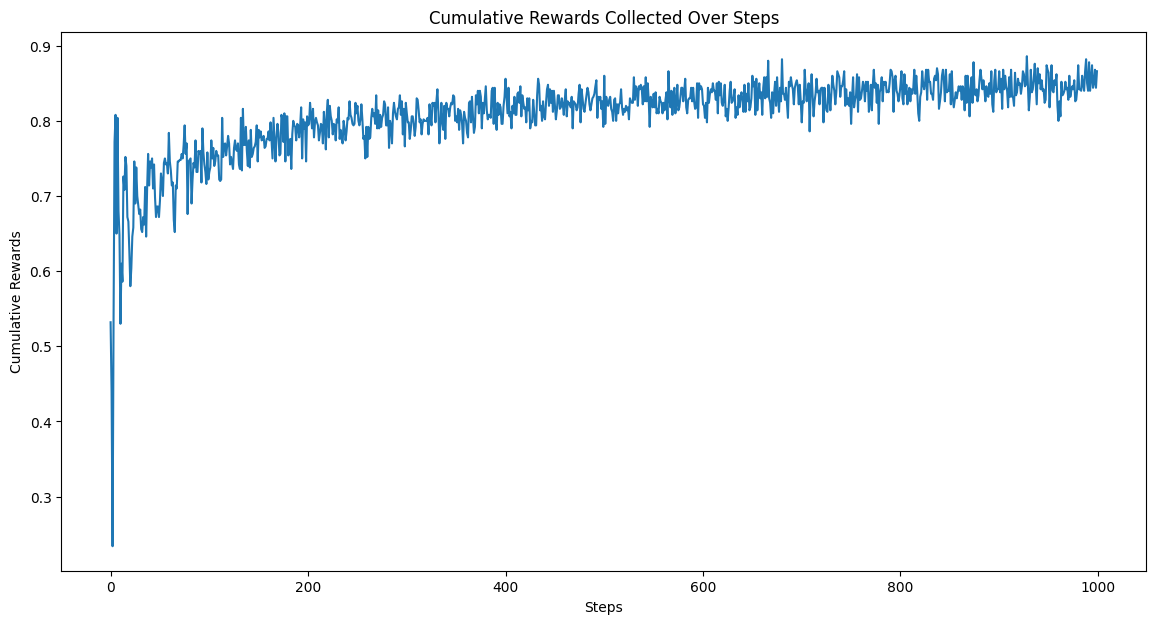

In [12]:
plot_cumulative_rewards(reward_history_avg)

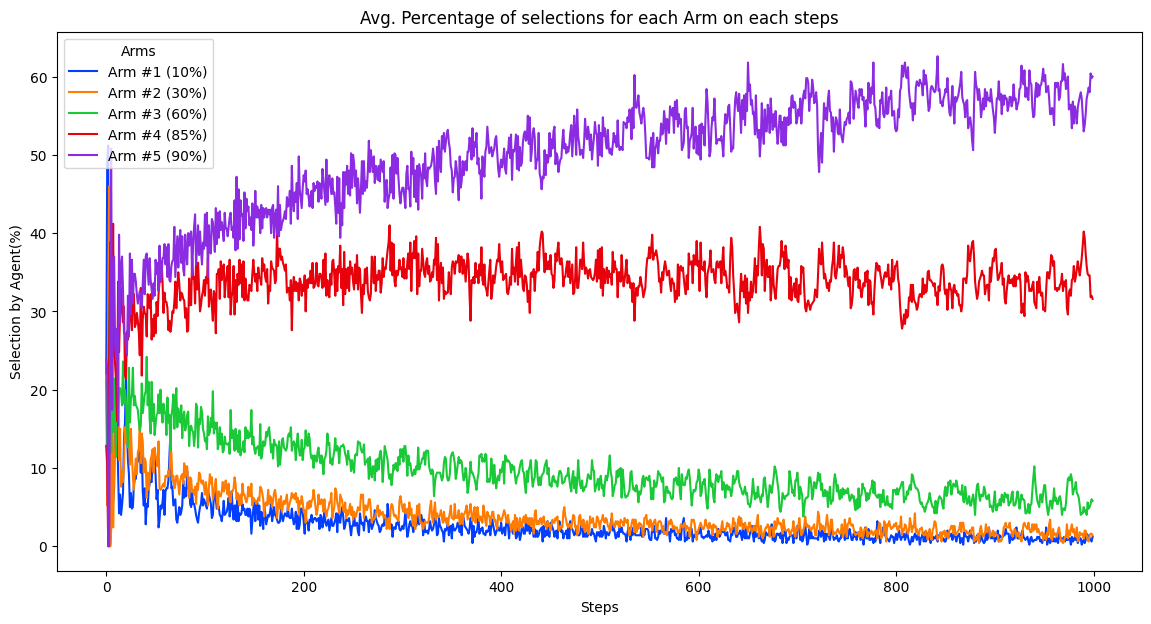

In [13]:
plot_arm_selection_percentage(action_history_avg, arms_prob)